# Model evaluation

The model performs image segmentation and output an image for each object tracked. The higher the value in the image, the more likely that the object was there. 

In [77]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch import optim
import torch
from datetime import datetime
import albumentations as A
import cv2

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet

In [3]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [0.5110162496566772, 0.4608974754810333, 0.4772901237010956], 'stds': [0.2727729380130768, 0.2578601539134979, 0.256255567073822]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [297]:
TRAIN_IMG_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_images"
TRAIN_MASK_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_masks" 
TRAIN_COORDINATE_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_coordinates" 
VAL_IMG_DIR = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_images"
VAL_MASK_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_masks"
VAL_COORDINATE_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_coordinates"
DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 
BATCH_SIZE=1
NUM_WORKERS=2
PIN_MEMORY=True

In [298]:
means = project.normalization_values["means"]
stds = project.normalization_values["stds"]
valTransform = A.Compose([A.Normalize(mean=means, std=stds)])

In [299]:
valDataset = UNetDataset(VAL_IMG_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform)
dataset = UNetDataset(VAL_IMG_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

In [153]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)


Let's get an item from the validation dataset

In [289]:
imageIndex=3
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

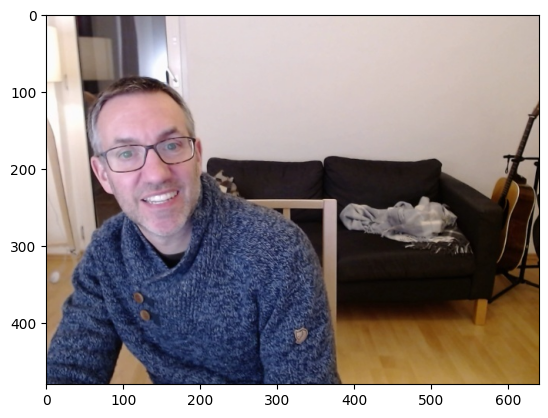

In [290]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [291]:
img = image.permute(1,2,0).numpy() #
msk = mask.numpy() 

Let's plot the image, and the mask for each tracked object

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


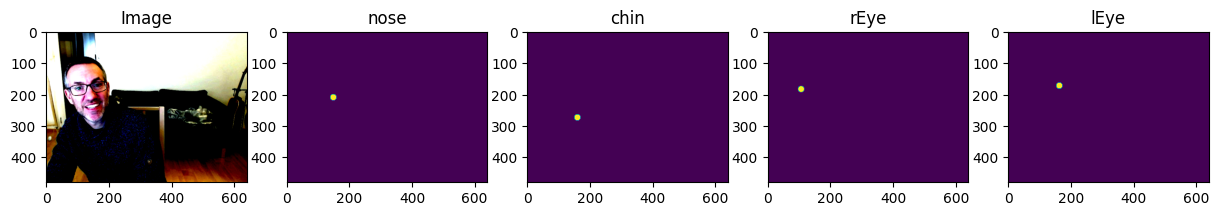

In [292]:
fig, ax = plt.subplots(1,msk.shape[0]+1,figsize=((msk.shape[0]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Image")
for i in range(msk.shape[0]):
    ax[i+1].imshow(msk[i])
    ax[i+1].set_title(project.object_list[i])

Let's get the model output for this image. 

If you use [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), you should apply a sigmoid function to the output as it is usually applied when calculating the loss. 

The sigmoid function limits the range from 0 to 1. 

In [293]:
image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.squeeze().detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


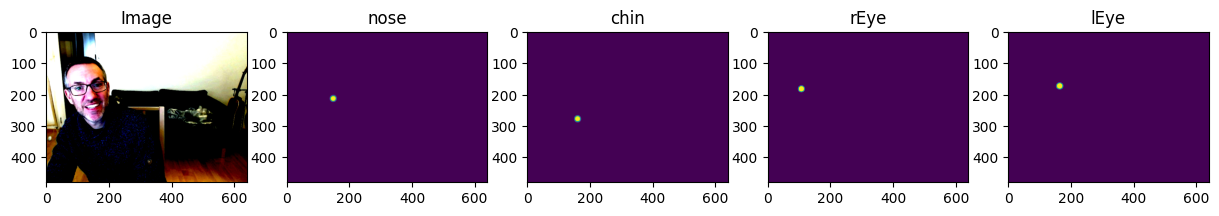

In [294]:
fig, ax = plt.subplots(1,output.shape[0]+1,figsize=((output.shape[0]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Image")
for i in range(output.shape[0]):
    ax[i+1].imshow(output[i])
    ax[i+1].set_title(project.object_list[i])


We can use the cv2.SimpleBlobDetector to detect the objects.

In [295]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 100 # between 400 and 500 is the decision point
detector = cv2.SimpleBlobDetector_create(params)

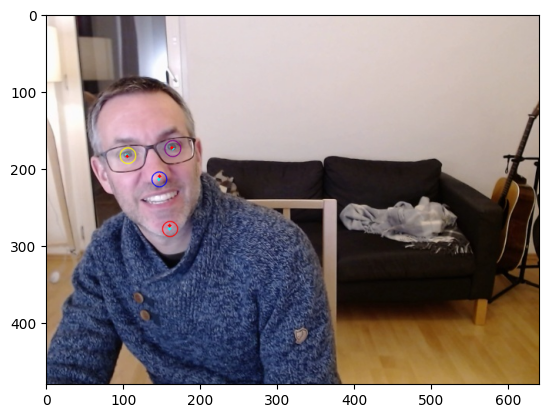

array([4.04701282, 4.50962321, 1.10234329, 1.59792874])

In [296]:
blobs = imageOri.astype(np.uint8)
pred = np.empty_like(coord)
pred[:,:] = np.nan

for objectIndex in range(len(project.object_list)):

    outputT = np.expand_dims((output[objectIndex]*255).astype(np.uint8),2) # get unsigned int 8 format 
    outputT= 255-outputT # reverse values

    keypoints = detector.detect(outputT)
    if keypoints:
        blank = np.zeros((1, 1))
        blobs = cv2.drawKeypoints(blobs, keypoints, blank, project.object_colors[objectIndex],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # find the largest blob
        largest_size=0
        pt = None
        for k in keypoints:
            if k.size>largest_size:
                pt = k.pt
        pred[objectIndex,0] = pt[0]
        pred[objectIndex,1] = pt[1]
        cv2.circle(blobs,(int(pt[0]),int(pt[1])), 2, (0,255,255), -1)
        cv2.circle(blobs,(int(coord[objectIndex,0]),int(coord[objectIndex,1])), 2, (255,0,0), -1)
plt.imshow(blobs)
plt.show()

# distance between predicted coordinates and labeled coordinates
np.sqrt(np.sum((coord-pred)**2,axis=1))
